In [1]:
import numpy as np
import librosa
import scipy.signal
import os
import sounddevice as sd
import soundfile as sf
import matplotlib.pyplot as plt
import sys

samplerate = 16000  # prefer for voice commands / speech recognition
channels = 1

In [119]:
def plot_audio(file_name,xmin=25, xmax = 90, show_plot=True):
    hp_cutoff = xmax   # Db, high-pass to remove rumble
    trim_top_db = xmin  # trim sections quieter than (max - trim_top_db) dB
    # 1) load
    y, sr = librosa.load(file_name, sr=samplerate, mono=True)
    # remove first 500 samples to avoid clicks
    y = y[5000:]
    
    # # 2) high-pass filter ( Butterworth )
    b, a = scipy.signal.butter(4, hp_cutoff / (sr / 2), btype='highpass')
    y_hp = scipy.signal.filtfilt(b, a, y)

    
    # 3) plot spectrogram
    # returns y_trim, index range (start, end)
    y_trim, idx = librosa.effects.trim(y_hp, top_db=trim_top_db)

    # 4) normalize (optional)
    # peak = np.max(np.abs(y_trim)) + 1e-9
    # y_out = 0.99 * y_trim / peak
    data = y_trim

    sd.play(data, samplerate)
    sd.wait()  
 
    plt.figure(figsize=(12, 4))
    plt.plot(data)
    plt.title(file_name)
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.show()
    if not show_plot:
        return data, sr

Saved to sample/custom3.wav


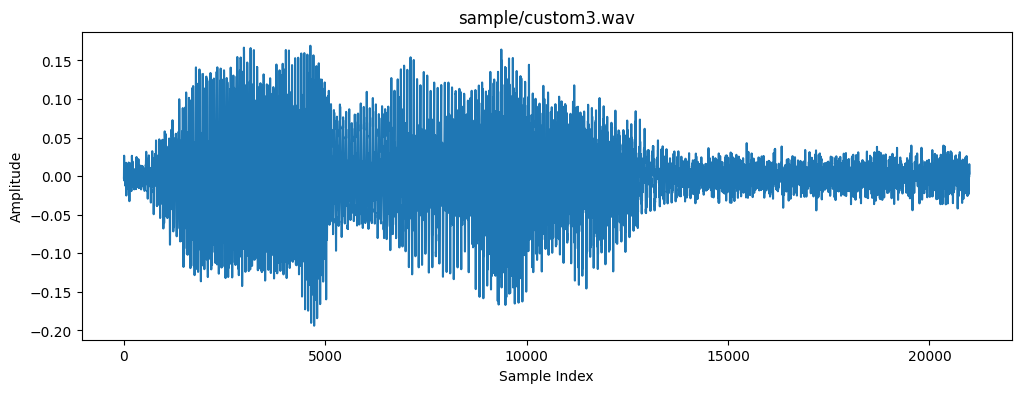

In [120]:
out_file = "sample/custom3.wav"

with sf.SoundFile(out_file, mode='w', samplerate=samplerate, channels=channels, subtype='PCM_16') as file:
    def callback(indata, frames, time, status):
        if status:
            print(status, file=sys.stderr)
        file.write(indata)
    with sd.InputStream(samplerate=samplerate, channels=channels, callback=callback):
        input("Recording... press Enter to stop\n")
print(f"Saved to {out_file}")
 
calx = plot_audio(out_file,15,80,False)

   

In [108]:
def max_cross_correlation(a, b):
    """Compute the maximum cross-correlation between two 1D arrays."""
    a = np.asarray(a).ravel().astype(float)
    b = np.asarray(b).ravel().astype(float)
    if len(a) == 0 or len(b) == 0:
        return 0.0, 0
    # optional: remove DC to compute correlation coefficient style
    # a = a - np.mean(a)
    # b = b - np.mean(b)
    corr = scipy.signal.correlate(a, b, mode='full') 
    max_idx = np.argmax(corr)
    max_corr = corr[max_idx]
    lag = max_idx - (len(b) - 1)
    plt.figure(figsize=(12, 4))
    plt.plot(corr)
    plt.title('Cross-Correlation')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.show()
    return float(max_corr), int(lag)


def max_normalized_cross_correlation(a, b):
    """
    Compute the maximum normalized cross-correlation and corresponding lag.

    The normalized cross-correlation is a value between -1 and 1, where:
    - 1 indicates a perfect match at a certain lag.
    - -1 indicates a perfect inverse match.
    - 0 indicates no linear relationship.
    """
    a = np.asarray(a).ravel().astype(float)
    b = np.asarray(b).ravel().astype(float)
    
    if len(a) == 0 or len(b) == 0:
        return 0.0, 0
    
    # Remove DC component (mean) for calculating the correlation coefficient
    a -= np.mean(a)
    b -= np.mean(b)
    
    # Calculate standard deviations for normalization
    a_std = np.std(a)
    b_std = np.std(b)
    
    if a_std == 0 or b_std == 0:
        # Avoid division by zero if a signal is constant
        return 0.0, 0
    
    # Compute the cross-correlation
    corr = scipy.signal.correlate(a, b, mode='full')
    
    # Normalize the cross-correlation result
    # The normalization factor is the product of the standard deviations and the number of points
    normalization = a_std * b_std * len(a)
    normalized_corr = corr / normalization
    
    # Find the peak of the normalized correlation
    max_idx = np.argmax(normalized_corr)
    max_corr = normalized_corr[max_idx]
    
    # Calculate the corresponding lag
    lags = scipy.signal.correlation_lags(len(a), len(b), mode='full')
    lag = lags[max_idx]
  
    plt.figure(figsize=(12, 4))
    plt.plot(lags, normalized_corr)
    plt.title('Normalized Cross-Correlation')
    plt.xlabel('Lag')
    plt.ylabel('Correlation Coefficient') 
    plt.show()
    return float(max_corr), int(lag)

Saved to sample/custom3.wav


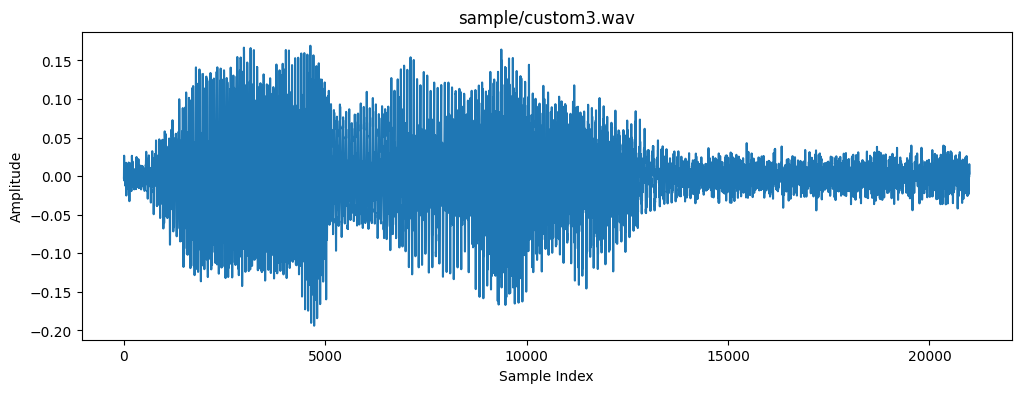

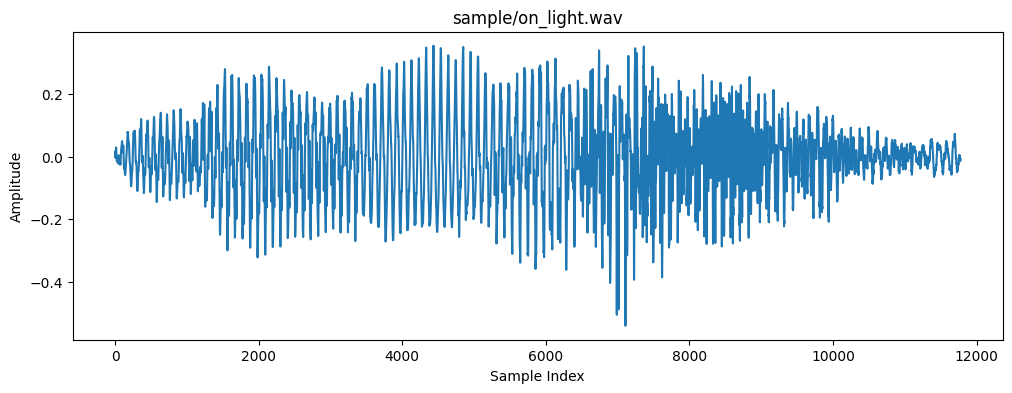

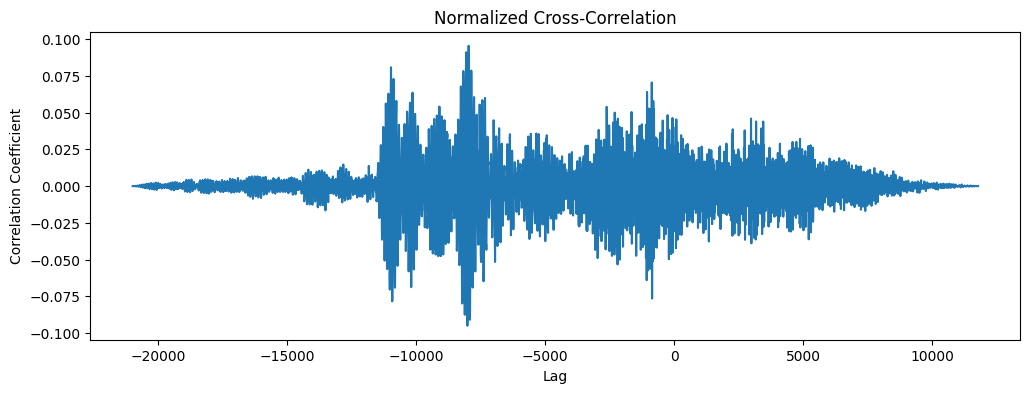

Command didn't match
Rating: 0.09557770018014233, Lag: -7971


In [121]:

out_file = "sample/custom3.wav"

# with sf.SoundFile(out_file, mode='w', samplerate=samplerate, channels=channels, subtype='PCM_16') as file:
#     def callback(indata, frames, time, status):
#         if status:
#             print(status, file=sys.stderr)
#         file.write(indata)
#     with sd.InputStream(samplerate=samplerate, channels=channels, callback=callback):
#         input("Recording... press Enter to stop\n")
print(f"Saved to {out_file}")
cal2 = plot_audio(out_file,15,80,False)


out_file = "sample/on_light.wav"
cal1 = plot_audio(out_file,15, 80, False) 

corr = max_normalized_cross_correlation(cal1[0], cal2[0])

rating = corr[0]
lag = corr[1]
if(rating > 0.6) and (abs(lag) < 3000):
    print("Command Matched")
    print(f"Rating: {rating}, Lag: {lag}")
else:
    print("Command didn't match")
    print(f"Rating: {rating}, Lag: {lag}")
 